In [1]:
import numpy as np
from itertools import product
import itertools
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
k = 5
p = 0.1
def maj(b):
    return 1 if np.sum(b) > k/2 else 0

def parity(b):
    return np.sum(b) % 2

def bool_func_from_signature(n, signature):
    """
    A signature of a boolean function is a length 2^n array that assigns
    a 0 or 1 to each input bitstring. The array is shape (2, )^n and the 
    value at each position is 0 or 1.
    """
    pass

### Find a counterexample

We want an example of data and noise such that MLD (for the noisy data) evaluated on noiseless data is _worse_ than MLD (for noiseless data) evaluated on noiseless data.

Suppose $f^*(z^{n-1}) = \argmax_{x'} p_{X|Z^{n-1}}(x|z^{n-1})$ is our MLD for noisy data and $g*(x^{n-1}) = \argmax_{x'} p_{X|X^{n-1}}(x|x^{n-1})$ is our MLD for noiseless data. We build $f^*$ analytically, then compare it to $g^*$. 

Our example will be $k=3$ majority function (in which case $g^*$ is just majority).

In [3]:
def s(f, x):
    """Compute the sensitivity of f at x"""
    n = len(x)
    out = 0
    for i in range(n):
        x_ = x.copy()
        x_[i] = 1 - x_[i]
        if f(x) != f(x_):
            out += 1
    return out

def average_sensitivity(f, X_arr):
    n = len(X_arr[0])
    out = 0
    for x in X_arr:
        out += s(f, x)
    return out / len(X_arr)

In [4]:
def bits_to_idx(b):
    out = 0
    for bit in b:
        out = (out << 1) | bit
    return out

def idx_to_bits(x, n):
    if x == 0: 
        return [0] * n
    bit = []
    while x:
        bit.append(x % 2)
        x >>= 1
    return (bit + [0] * (n-len(bit)))[::-1]

bits_to_idx(idx_to_bits(22, 7)) == 22 and idx_to_bits(bits_to_idx([1, 0, 0, 1, 0]), 5) == [1, 0, 0, 1, 0]

True

In [5]:
def generate_noisy_distr(n, p, f):
    """For a true label function f, generate a distribution p_{Z, Y}
    where Y = f(X). 

    ASSUMES UNIFORM DISTR FOR X

    we will return P_{Z, Y}(z, y) with shape (2**n, 2)
    
    """
    out = np.zeros((2 ** n, 2))
    for i, x in enumerate(itertools.product([0, 1], repeat=n)):
        p_x = 1 / 2 ** n
        y = int(f(x))
        for e in product([0, 1], repeat=n):
            p_z_given_x = p ** np.sum(e) * (1 - p) ** (n - np.sum(e))
            z = np.array(x) ^ np.array(e)
            z_idx = bits_to_idx(z)
            out[z_idx, y] += p_z_given_x * p_x

    return out

def compute_acc_noisytest(p_zy, func, n):
    """THIS ONLY WORKS FOR X UNIFORM DISTRIBUTION!"""
    acc = 0
    for i, p_zy in enumerate(p_zy):
        # p_z = np.sum(p_zy)
        bitstring = idx_to_bits(i, n)
        pred = func(bitstring)
        acc += p_zy[pred]

    return acc

def compute_acc_test(func, true_func, n):
    """assumes x is uniform distribution"""
    acc = 0
    for i, x in enumerate(itertools.product([0, 1], repeat=n)):
        truth = true_func(x)
        pred = func(x)
        if truth == pred:
            acc += 1 / 2 ** n
    return acc

### Brute-force for $n \leq 4$

In [6]:
# n = 5

raise ValueError("don't run this")
def boolean_function_from_signature(f):
    """Given a length 2^n binary array, return the function with that boolean signature."""
    X_arr = list(itertools.product([0, 1], repeat=n))
    X_arr = [tuple(x) for x in X_arr]
    lookup = dict(zip(X_arr, f))
    def func(x):
        return lookup[tuple(x)]
    return lookup, func

n = 4
assert n <= 4
k = n
pvals = [0.01, 0.25, 0.49]

# a "signature" of a boolean function is a length 2**n bitstring S where f(x) = S[bin(x)]
sig_arr = np.array(list(itertools.product([0, 1], repeat=2 ** n)))
X_arr = np.array(list(itertools.product([0, 1], repeat=n)))
p_x = 1 / (2 ** k) # uniform distribution over x
for i, signature in enumerate(sig_arr):
    # iterate over signatures
    dct, func = boolean_function_from_signature(signature)
    for p in pvals:        
        # noisy_lookup[row,col] is the JOINT probability Pr(f(z)=row| x=col)
        noisy_lookup = np.zeros((2, 2**n))
        true_lookup = np.zeros((2, 2**n))
        # simulate a noisy dataset essentially
        for i, x in enumerate(product([0,1], repeat=k)):
            func_value = func(x)
            # true lookup is an array with 2 rows; there is a p_x at [row, column] if 
            # f[column] = row]. so, true_lookup[i, j] = pr(f(x) = i| x=j)
            true_lookup[func(x), i] = 1
            # iterate over all of the z values that contribute to 
            for e in product([0, 1], repeat=k):
                z = np.array(x) ^ np.array(e)
                p_x_given_z = p ** sum(e) * (1-p)**(k - sum(e))
                # increment noisy_lookup at the binary index of z
                # noisy_lookup[i, j] = pr(f(z) = i,  x=j) 
                noisy_lookup[func_value, int(''.join(map(str, z)), 2)] += p_x_given_z 
        
        # the function is balanced if the sums of the two rows of true_lookup are equal
        # imbal = abs(true_lookup[0,:].sum() - true_lookup[1,:].sum())  / 2 ** n
        # round up to get argmax 
        noisy_mle = np.round(noisy_lookup)  
        out = np.multiply(noisy_mle, true_lookup) / 2 ** n # "inner product" of the functions
        diff = out.sum()
        fnstar_dct = {}
        for i, x in enumerate(X_arr):
            fnstar_dct[tuple(x)] = np.argmax(noisy_lookup[:, i])
        def fnstar(x):
            return fnstar_dct[tuple(x)]
        
        sensitivity_f = average_sensitivity(func, X_arr)
        sensitivity_fnstar = average_sensitivity(fnstar, X_arr)
        sensitivity_diff = sensitivity_f - sensitivity_fnstar
        # accuracies on dataset
        p_zy = generate_noisy_distr(k, p, func)
        noisy_f_acc = compute_acc_noisytest(p_zy, func, n) # accuracy of f on noisy data
        # noiseless_fnstar_acc = compute_acc_test(fnstar, func, n) # accuracy of fN* on noiseless data
        noisy_fnstar_acc = compute_acc_noisytest(p_zy, fnstar, n) # accuracy of fN* MLE on noisy data
        if sensitivity_f < sensitivity_fnstar:
            print("ERROR: fn* has lower sensitivity than f")
            raise ValueError


ValueError: don't run this

### Counterexamples computations
Here we search over functions where $f(x) = g(\text{wt}(x))$

counterexample= [1, 0, 0, 1, 1, 0]
	 noisy fnstar acc= [np.float64(0.6042299999999998)]
	 noisy fnstar sensitivity= 1.875
	 noisy f acc= [np.float64(0.5828199999999999)]
	 noisy f sensitivity= 2.5
(np.float64(0.6042299999999998), 1.875) (np.float64(0.5828199999999999), 2.5)



#### Searching for counterexamples

Instead of defining boolean functions as $f:\{0,1\}^n \rightarrow \{0,1\}$, we define $f$ such that 
$$
f(x) = g(\text{wt}(x))
$$
what this does is, there are only $2^{n+1}$ possible functions $g$, instead of $2^{2^n}$ possible functions $f$. For example, if $n=3$, then a possible $g$ is 
\begin{equation}
     \text{wt}(x) \rightarrow \begin{cases}
        0 \rightarrow 0 \\
        1 \rightarrow 1 \\
        2 \rightarrow 0 \\
        3 \rightarrow 1
    \end{cases}
\end{equation}

In [ ]:
# n = 5
n = 5
k = n
pvals = [0, 0.1, 0.2, 0.3]

X_arr = np.array(list(itertools.product([0, 1], repeat=n)))
p_x = 1 / (2 ** k) # uniform distribution over x

# counterexamples = [
#     [1,0,0,1,1,0],
#     [0,1,1,0,1,0],
#     [0,1,1,0,0,0]
# ]

counterexamples = itertools.product([0, 1], repeat=n+1)

# H = [[0, 1, 0, 0, 0]]
print("boolean signature | imbal? | Pr(fN*=f) | taccfN* |naccfN*-naccf| S(f) | S(fN*) | S(f) - S(fN*)")
print("--------------------------------------------------------------------------")
for i, signature in enumerate(counterexamples):
    print("signature=", signature)
    f_accs = []
    fn_accs = []
    f_sens = []
    fn_sens = []
    for p in pvals:
        hash = dict(zip(range(n+1), signature))
        func = lambda b: hash[sum(b)]
        
        # noisy_lookup[row,col] is the JOINT probability Pr(f(z)=row| x=col)
        noisy_lookup = np.zeros((2, 2**n))
        true_lookup = np.zeros((2, 2**n))
        # simulate a noisy dataset essentially
        for i, x in enumerate(product([0,1], repeat=k)):
            func_value = func(x)
            # true lookup is an array with 2 rows; there is a p_x at [row, column] if 
            # f[column] = row]. so, true_lookup[i, j] = pr(f(x) = i| x=j)
            true_lookup[func(x), i] = 1
            # iterate over all of the z values that contribute to 
            for e in product([0, 1], repeat=k):
                z = np.array(x) ^ np.array(e)
                p_x_given_z = p ** sum(e) * (1-p)**(k - sum(e))
                # increment noisy_lookup at the binary index of z
                # noisy_lookup[i, j] = pr(f(z) = i,  x=j) 
                noisy_lookup[func_value, int(''.join(map(str, z)), 2)] += p_x_given_z 
        
        # the function is balanced if the sums of the two rows of true_lookup are equal
        imbal = abs(true_lookup[0,:].sum() - true_lookup[1,:].sum())  / 2 ** n
        
        # if not balanced:
        #     continue
        # round up to get argmax 
        noisy_mle = np.round(noisy_lookup)  
        out = np.multiply(noisy_mle, true_lookup) / 2 ** n # "inner product" of the functions
        diff = out.sum()


        fnstar_dct = {}
        for i, x in enumerate(X_arr):
            fnstar_dct[tuple(x)] = np.argmax(noisy_lookup[:, i])
        def fnstar(x):
            return fnstar_dct[tuple(x)]
        
        sensitivity_f = average_sensitivity(func, X_arr)
        sensitivity_fnstar = average_sensitivity(fnstar, X_arr)
        sensitivity_diff = sensitivity_f - sensitivity_fnstar
        # accuracies on dataset
        p_zy = generate_noisy_distr(k, p, func)
        noisy_f_acc = compute_acc_noisytest(p_zy, func, n) # accuracy of f on noisy data
        noiseless_fnstar_acc = compute_acc_test(fnstar, func, n) # accuracy of fN* on noiseless data
        noisy_fnstar_acc = compute_acc_noisytest(p_zy, fnstar, n) # accuracy of fN* MLE on noisy data

        acc_diff = noisy_fnstar_acc - noisy_f_acc
        f_accs.append(noisy_f_acc)
        fn_accs.append(noisy_fnstar_acc)
        f_sens.append(sensitivity_f)
        fn_sens.append(sensitivity_fnstar)

    print("\t pvals=", pvals)
    print("\t noisy fnstar acc=", fn_accs)
    print("\t noisy f acc=", f_accs)
    print("\t noisy fnstar sensitivity=", fn_sens)
    print("\t true f sensitivity=", f_sens)
    print()


boolean signature | imbal? | Pr(fN*=f) | taccfN* |naccfN*-naccf| S(f) | S(fN*) | S(f) - S(fN*)
--------------------------------------------------------------------------
signature= (0, 0, 0, 0, 0, 0)
	 pvals= [0, 0.1, 0.2, 0.3]
	 noisy fnstar acc= [np.float64(1.0), np.float64(1.0), np.float64(1.0000000000000002), np.float64(0.9999999999999998)]
	 noisy f acc= [np.float64(1.0), np.float64(1.0), np.float64(1.0000000000000002), np.float64(0.9999999999999998)]
	 noisy fnstar sensitivity= [0.0, 0.0, 0.0, 0.0]
	 noisy f sensitivity= [0.0, 0.0, 0.0, 0.0]

signature= (0, 0, 0, 0, 0, 1)
	 pvals= [0, 0.1, 0.2, 0.3]
	 noisy fnstar acc= [np.float64(1.0), np.float64(0.9744056249999998), np.float64(0.9687500000000006), np.float64(0.9687499999999993)]
	 noisy f acc= [np.float64(1.0), np.float64(0.9744056249999998), np.float64(0.9579800000000006), np.float64(0.9480043749999993)]
	 noisy fnstar sensitivity= [0.3125, 0.3125, 0.0, 0.0]
	 noisy f sensitivity= [0.3125, 0.3125, 0.3125, 0.3125]

signature= (

In [17]:
def random_boolean_function(n):
    X_arr = list(itertools.product([0, 1], repeat=n))
    X_arr = [tuple(x) for x in X_arr]
    f = np.random.randint(2, size=2**n, dtype=int)
    f = [x.item() for x in f]
    lookup = dict(zip(X_arr, f))
    def func(x):
        return lookup[tuple(x)]
    return lookup, func


#### Random search over boolean functions

In [27]:


n = 6 # n=7 takes about .5 second per trial
# p = 0.45
p = np.random.random()/2
trials = 100

X_arr = np.array(list(itertools.product([0, 1], repeat=n)))
p_x = 1 / (2 ** n) # uniform distribution over x
out = []
for j in range(trials):
    dct = {"j": j}
    lookup, func = random_boolean_function(n)
    
    # noisy_lookup[row,col] is the JOINT probability Pr(f(z)=row| x=col)
    noisy_lookup = np.zeros((2, 2**n))
    true_lookup = np.zeros((2, 2**n))
    # simulate a noisy dataset essentially
    for i, x in enumerate(product([0,1], repeat=n)):
        x = tuple(x)
        func_value = func(x)
        # true lookup is an array with 2 rows; there is a p_x at [row, column] if 
        # f[column] = row]. so, true_lookup[i, j] = pr(f(x) = i| x=j)
        true_lookup[func(x), i] = 1
        # iterate over all of the z values that contribute to 
        for e in product([0, 1], repeat=n):
            z = np.array(x) ^ np.array(e)
            p_x_given_z = p ** sum(e) * (1-p)**(n - sum(e))
            # increment noisy_lookup at the binary index of z
            # noisy_lookup[i, j] = pr(f(z) = i,  x=j) 
            noisy_lookup[func_value, int(''.join(map(str, z)), 2)] += p_x_given_z 
    
    # the function is balanced if the sums of the two rows of true_lookup are equal
    imbal = abs(true_lookup[0,:].sum() - true_lookup[1,:].sum())  / 2 ** n

    fnstar_dct = {}
    for i, x in enumerate(X_arr):
        fnstar_dct[tuple(x)] = np.argmax(noisy_lookup[:, i])
    def fnstar(x):
        return fnstar_dct[tuple(x)]
    
    sensitivity_f = average_sensitivity(func, X_arr)
    sensitivity_fnstar = average_sensitivity(fnstar, X_arr)
    sensitivity_diff = sensitivity_f - sensitivity_fnstar
    # accuracies on dataset
    noiseless_fnstar_acc  = compute_acc_test(fnstar, func, n) # accuracy of fN* on noiseless data

    p_zy = generate_noisy_distr(n, p, func)
    noisy_f_acc = compute_acc_noisytest(p_zy, func, n) # accuracy of f on noisy data
    noisy_fnstar_acc = compute_acc_noisytest(p_zy, fnstar, n) # accuracy of fN* MLE on noisy data
    nacc_diff = noisy_fnstar_acc - noisy_f_acc
    dct.update({
        "imbal": imbal,
        "noisy_acc_fnstar": noisy_fnstar_acc,
        "noiseless_acc_fnstar": noiseless_fnstar_acc,
        "sensitivity_f": sensitivity_f,
        "sensitivity_fnstar": sensitivity_fnstar,
    })
    out.append(dct)

    if sensitivity_f < sensitivity_fnstar:
        print("COUNTEREXAMPLE")
        print("sensitivity_f", sensitivity_f)
        print("sensitivity_fnstar", sensitivity_fnstar)
        print("f", func)
        print("fnstar", fnstar)
    # if sensitivity_f > sensitivity_fnstar and sensitivity_fnstar > 0:
    #     for k, v in fnstar_dct.items():
    #         fnstar_dct[tuple([int(x) for x in k])] = int(v)
    #     for k in lookup.keys():
    #         print(k, lookup[k], fnstar_dct[k])
    #     print(sensitivity_f - sensitivity_fnstar)
    #     print("fnstar sensitivity", sensitivity_fnstar)
    #     print("f sensitivity", sensitivity_f)
    #     print()

df = pd.DataFrame(out)


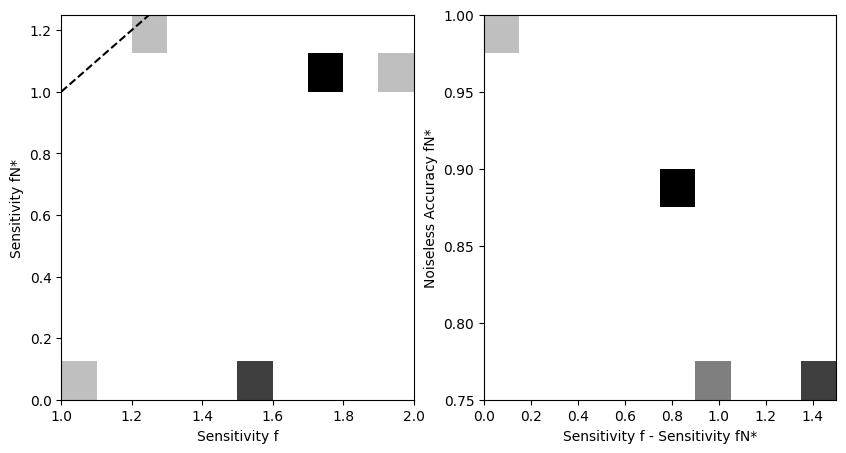

In [ ]:
df.head()

sf = df["sensitivity_f"] 
sfn = df["sensitivity_fnstar"] 
fn_noiseless_acc = df["noiseless_acc_fnstar"]


fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].hist2d(sf, sfn, cmap='binary')

# axes[0].scatter(sf, sfn)
# use square aspect
axes[0].set_xlabel("Sensitivity f")
axes[0].set_ylabel("Sensitivity fN*")
# axes[0].set_xlim(axes[0].get_ylim())
axes[0].plot([min(sf), max(sf)], [min(sf), max(sf)], ls='--', c='k')

# 2D histogram of sf-sfn vs fn_noiseless_acc
axes[1].hist2d(sf-sfn, fn_noiseless_acc,  cmap='binary')
axes[1].set_xlabel("Sensitivity f - Sensitivity fN*")
axes[1].set_ylabel("Noiseless Accuracy fN*")
# axes[1].axhline(1 - p/2)
print()

In [ ]:
round(.319*100, 3)


31.9

In [ ]:
# n = 5
n = 5
k = n
# p = 0.2
pvals = [0, 0.1, 0.15, 0.2, 0.25, 0.3]

X_arr = np.array(list(itertools.product([0, 1], repeat=n)))


p_x = 1 / (2 ** k) # uniform distribution over x

H = np.array(list(itertools.product([0, 1], repeat=n+1)))
mine = [
    [1,0,0,1,1,0],
    [0,1,1,0,1,0],
    [0,1,1,0,0,0]
]
# H = [[0, 1, 0, 0, 0]]

for p in pvals:
    print()
    print(f"!!!p={p}")
    print("boolean signature | imbal? | nacc(fN*) | taccfN* |naccfN*-naccf| S(f) | S(fN*) | S(f) - S(fN*)")
    print("--------------------------------------------------------------------------")
    for i, signature in enumerate(H):
        sss = "  "
        if list(signature) in mine:
            sss = ">>"
        hash = dict(zip(range(n+1), signature))
        func = lambda b: hash[sum(b)]
        
        # noisy_lookup[row,col] is the JOINT probability Pr(f(z)=row| x=col)
        noisy_lookup = np.zeros((2, 2**n))
        true_lookup = np.zeros((2, 2**n))
        # simulate a noisy dataset essentially
        for i, x in enumerate(product([0,1], repeat=k)):
            func_value = func(x)
            # true lookup is an array with 2 rows; there is a p_x at [row, column] if 
            # f[column] = row]. so, true_lookup[i, j] = pr(f(x) = i| x=j)
            true_lookup[func(x), i] = 1
            # iterate over all of the z values that contribute to 
            for e in product([0, 1], repeat=k):
                z = np.array(x) ^ np.array(e)
                p_x_given_z = p ** sum(e) * (1-p)**(k - sum(e))
                # increment noisy_lookup at the binary index of z
                # noisy_lookup[i, j] = pr(f(z) = i,  x=j) 
                noisy_lookup[func_value, int(''.join(map(str, z)), 2)] += p_x_given_z 
        
        # the function is balanced if the sums of the two rows of true_lookup are equal
        imbal = abs(true_lookup[0,:].sum() - true_lookup[1,:].sum())  / 2 ** n
        
        # if not balanced:
        #     continue
        # round up to get argmax 
        noisy_mle = np.round(noisy_lookup)  
        out = np.multiply(noisy_mle, true_lookup) / 2 ** n # "inner product" of the functions
        noiseless_fnstar_acc = out.sum()


        fnstar_dct = {}
        for i, x in enumerate(X_arr):
            fnstar_dct[tuple(x)] = np.argmax(noisy_lookup[:, i])
        def fnstar(x):
            return fnstar_dct[tuple(x)]
        
        sensitivity_f = average_sensitivity(func, X_arr)
        sensitivity_fnstar = average_sensitivity(fnstar, X_arr)
        sensitivity_diff = sensitivity_f - sensitivity_fnstar
        # accuracies on dataset
        #  = compute_acc_test(fnstar, func, n) # accuracy of fN* on noiseless data

        p_zy = generate_noisy_distr(k, p, func)
        noisy_f_acc = compute_acc_noisytest(p_zy, func, n) # accuracy of f on noisy data
        noisy_fnstar_acc = compute_acc_noisytest(p_zy, fnstar, n) # accuracy of fN* MLE on noisy data
        nacc_diff = noisy_fnstar_acc - noisy_f_acc



        print(f"{sss}{signature}   | {imbal:0.4f} |   {noisy_fnstar_acc:1.4f}  | {noiseless_fnstar_acc:1.4f} | {nacc_diff:1.4f}    |{sensitivity_f:1.4f}|{sensitivity_fnstar:1.4f}  |  {sensitivity_diff:1.4f} ")
        if sensitivity_fnstar == 0:
            topr = sum(noisy_mle[0,:])
            botr = sum(noisy_mle[1,:])
            assert (np.allclose(topr, 0) or np.allclose(topr, 1 << n))
            assert (np.allclose(botr, 0) or np.allclose(botr, 1 << n))

    
    



!!!p=0
boolean signature | imbal? | nacc(fN*) | taccfN* |naccfN*-naccf| S(f) | S(fN*) | S(f) - S(fN*)
--------------------------------------------------------------------------
  [0 0 0 0 0 0]   | 1.0000 |   1.0000  | 1.0000 | 0.0000    |0.0000|0.0000  |  0.0000 
  [0 0 0 0 0 1]   | 0.9375 |   1.0000  | 1.0000 | 0.0000    |0.3125|0.3125  |  0.0000 
  [0 0 0 0 1 0]   | 0.6875 |   1.0000  | 1.0000 | 0.0000    |1.5625|1.5625  |  0.0000 
  [0 0 0 0 1 1]   | 0.6250 |   1.0000  | 1.0000 | 0.0000    |1.2500|1.2500  |  0.0000 
  [0 0 0 1 0 0]   | 0.3750 |   1.0000  | 1.0000 | 0.0000    |3.1250|3.1250  |  0.0000 
  [0 0 0 1 0 1]   | 0.3125 |   1.0000  | 1.0000 | 0.0000    |3.4375|3.4375  |  0.0000 
  [0 0 0 1 1 0]   | 0.0625 |   1.0000  | 1.0000 | 0.0000    |2.1875|2.1875  |  0.0000 
  [0 0 0 1 1 1]   | 0.0000 |   1.0000  | 1.0000 | 0.0000    |1.8750|1.8750  |  0.0000 
  [0 0 1 0 0 0]   | 0.3750 |   1.0000  | 1.0000 | 0.0000    |3.1250|3.1250  |  0.0000 
  [0 0 1 0 0 1]   | 0.3125 |   1.0000  

In [ ]:
np.argmax(noisy_lookup[:,0])

np.int64(1)

In [ ]:
print(noisy_mle)

[[0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1.]]


In [ ]:
# We will build the conditional p_{X|Z^{n-1}}(x|z^{n-1}) one at a time for each x and z^{n-1}
k = 5
p = 0.44

noisy_lookup = np.zeros((2, 2**k))
true_lookup = np.zeros((2, 2**k))
func = parity
# simulate a noisy dataset essentially
for i, x in enumerate(product([0,1], repeat=k)):
    p_x = 1 / (2 ** k) 
    func_value = func(x)
    true_lookup[func(x), i] = p_x
    for e in product([0, 1], repeat=k):
        p_e = p ** sum(e) * (1-p)**(k - sum(e))
        z = np.array(x) ^ np.array(e)
        p_z = p_x * p_e
        # increment noisy_lookup at the binary index of z
        noisy_lookup[func_value, int(''.join(map(str, z)), 2)] += p_e


out = np.multiply(np.round(noisy_lookup), true_lookup)
print(out)
print(out.sum())

[[0.01562539 0.         0.         0.01562539 0.         0.01562539
  0.01562539 0.         0.         0.01562539 0.01562539 0.
  0.01562539 0.         0.         0.01562539 0.         0.01562539
  0.01562539 0.         0.01562539 0.         0.         0.01562539
  0.01562539 0.         0.         0.01562539 0.         0.01562539
  0.01562539 0.        ]
 [0.         0.01562539 0.01562539 0.         0.01562539 0.
  0.         0.01562539 0.01562539 0.         0.         0.01562539
  0.         0.01562539 0.01562539 0.         0.01562539 0.
  0.         0.01562539 0.         0.01562539 0.01562539 0.
  0.         0.01562539 0.01562539 0.         0.01562539 0.
  0.         0.01562539]]
0.5000124416
[[0.03125 0.      0.      0.03125 0.      0.03125 0.03125 0.      0.
  0.03125 0.03125 0.      0.03125 0.      0.      0.03125 0.      0.03125
  0.03125 0.      0.03125 0.      0.      0.03125 0.03125 0.      0.
  0.03125 0.      0.03125 0.03125 0.     ]
 [0.      0.03125 0.03125 0.      0.03125

[[0.03125 0.      0.      0.03125 0.      0.03125 0.03125 0.      0.
  0.03125 0.03125 0.      0.03125 0.      0.      0.03125 0.      0.03125
  0.03125 0.      0.03125 0.      0.      0.03125 0.03125 0.      0.
  0.03125 0.      0.03125 0.03125 0.     ]
 [0.      0.03125 0.03125 0.      0.03125 0.      0.      0.03125 0.03125
  0.      0.      0.03125 0.      0.03125 0.03125 0.      0.03125 0.
  0.      0.03125 0.      0.03125 0.03125 0.      0.      0.03125 0.03125
  0.      0.03125 0.      0.      0.03125]]
1.0
